- - - --------------------------------------------------------------------
# ```OPTIMISATION```  
# Dimensionnement de stockage embarqué dans un tramway
- ----------------------------------------------------------------------


## Objectifs du projet :
- Mettre en œuvre une démarche d’optimisation pour la conception d’un système
- Comprendre le principe de l’alimentation électrique des tramways
- Découvrir l’optimisation multi-critères et le concept d’optimalité au sens de Pareto
- Mettre en œuvre l’algorithme génétique NSGA-2

## Presentation du systeme de tramway etudie 

Ce projet porte sur l’étude en simulation d’une ligne de tramway, et plus précisément sur
l’intérêt d’un système de stockage par batterie à bord afin de faire de la récupération d’énergie au
freinage. On souhaite dimensionner et piloter un système de stockage de façon à réduire les chutes de
tension aux bornes du train. Pour cela, il faut réaliser un compromis entre coût et performance du
système de stockage. 

In [197]:
import scipy.io
import scipy.optimize
import numpy as np 
import matplotlib.pyplot as plt
import random

###  Recuperation des données 


In [100]:
marche = 'marche.txt'
donnee = np.loadtxt(marche)

t= donnee[:, 0] # Temps en seconde 
x = donnee[:, 1] # Position du train en mètrese
dt = t[1] - t[0] # Pas de temps 

### Definition des parametres :


In [101]:
# Données du systeme 
M = 70e3 # Masse du train 
g = 9.81 # Accélération gravitationnelle en m/s^2
A0 , A1 = 780 , 6.4e-3 #Coef de  résistance 
B0, B1 = 0, 0.14e-3*3.6 # Résistance proportionnelle à la vitesse (N/(km/h))
C0, C1 = 0.3634*3.6**2, 0  # Résistance quadratique en fonction de la vitesse (N/(km/h)^2)
alpha = 0  # Pente de la voie (en radians)
eta_conversion = 0.8 # Rendement moteur 
eta_batterie=0.9 # Rendement batterie 
P_bord = 35e3  # Puissance constante à bord en W


# Données électriques
V_ss1 = 790  # Tension des sous-stations (V)
R_ss1 = 33e-3  # Résistance interne des sous-stations (ohms)
rho_LAC = 95e-6  # Résistance linéique de la LAC (ohms/m)
rho_rail = 10e-6  # Résistance linéique des rails (ohms/m)


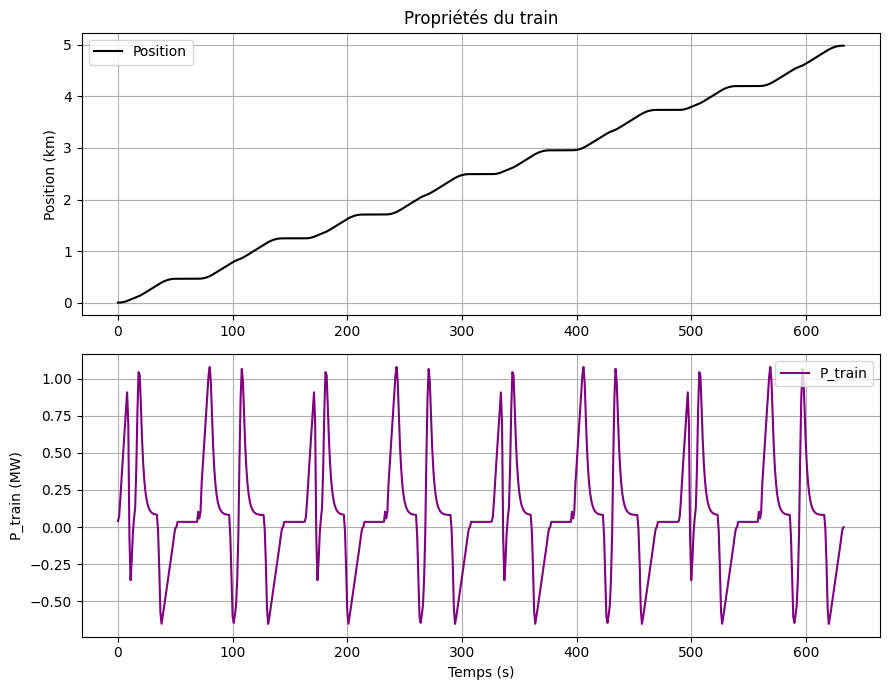

/var/folders/g0/d62p30gx3nd97fz5_9qbz5280000gn/T/ipykernel_1746/2677381557.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


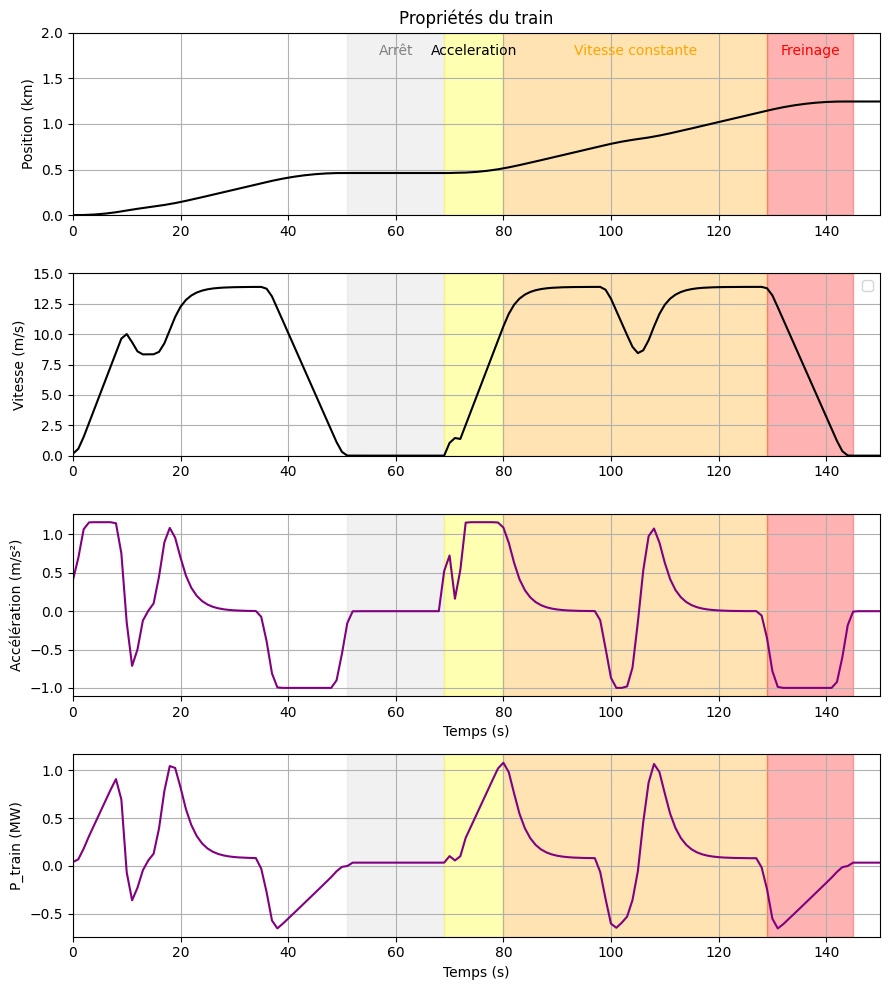

In [190]:

# Calcul de la vitesse (m/s) et de l'accélération (m/s^2)
v = np.gradient(x, dt)  # Vitesse 
a = np.gradient(v, dt)  # Accélération 

# Calcul des forces appliquées
F_gravity = M * g * np.sin(alpha)  # Force gravitationnelle
F_resistance = (A0 + A1 * M) + (B0 + B1 * M) * v + (C0 + C1 * M) * v**2     # Résistance au déplacement
F_moteur = M * a + F_resistance  # Force motrice requise

# Calcul de la puissance mécanique
P_meca = F_moteur * v  # Puissance mécanique en W

# Calcul de la puissance électrique totale
P_train = np.zeros_like(P_meca)  # Initialisation de P_train

for i in range(len(P_meca)):
   if P_meca[i] >= 0:  # Le moteur consomme de l'énergie
       P_train[i] = (P_meca[i] / eta_conversion) + P_bord
   else:  # Le moteur restitue de l'énergie
       P_train[i] = (P_meca[i] * eta_conversion)

plt.figure(figsize=(9, 7))
# Position
plt.subplot(2, 1, 1)
plt.plot(t, x * 1e-3, label='Position', color='black')
plt.ylabel("Position (km)")
plt.title("Propriétés du train")
plt.legend()
plt.grid()

# Puissance
plt.subplot(2, 1, 2)
plt.plot(t, P_train / 1e6, label='P_train', color='purple')
plt.xlabel("Temps (s)")
plt.ylabel("P_train (MW)")
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()
# Détection des phases
phases = {
    'arret': [51, 69],
    'demarrage': [69, 80],
    'vitesse_constante': [80, 129],
    'freinage': [129, 145]
}


plt.figure(figsize=(9, 10))

# Position
plt.subplot(4, 1, 1)
plt.plot(t, x * 1e-3,  color='black')
plt.ylabel("Position (km)")
plt.title("Propriétés du train")
plt.xlim(0, 150)
plt.ylim(0, 2)
plt.grid()

# Ajout des fonds colorés pour les phases
plt.axvspan(phases['arret'][0], phases['arret'][1], color='lightgrey', alpha=0.3)  # Arret
plt.axvspan(phases['demarrage'][0], phases['demarrage'][1], color='yellow', alpha=0.3)  # Demarrage
plt.axvspan(phases['vitesse_constante'][0], phases['vitesse_constante'][1], color='orange', alpha=0.3)  # Vitesse constante
plt.axvspan(phases['freinage'][0], phases['freinage'][1], color='red', alpha=0.3)  # Freinage

# Ajout des textes dans les intervalles
plt.text((phases['arret'][0] + phases['arret'][1]) / 2, 1.8, 'Arrêt', color='grey', ha='center', va='center')
plt.text((phases['demarrage'][0] + phases['demarrage'][1]) / 2, 1.8, 'Acceleration', color='black', ha='center', va='center')
plt.text((phases['vitesse_constante'][0] + phases['vitesse_constante'][1]) / 2, 1.8, 'Vitesse constante', color='orange', ha='center', va='center')
plt.text((phases['freinage'][0] + phases['freinage'][1]) / 2, 1.8, 'Freinage', color='red', ha='center', va='center')

# Vitesse
plt.subplot(4, 1, 2)
plt.plot(t, v,  color='black')
plt.ylabel("Vitesse (m/s)")
plt.legend()
plt.xlim(0, 150)
plt.ylim(0, 15)
plt.grid()

# Ajout des fonds colorés pour les phases
plt.axvspan(phases['arret'][0], phases['arret'][1], color='lightgrey', alpha=0.3)  # Arret
plt.axvspan(phases['demarrage'][0], phases['demarrage'][1], color='yellow', alpha=0.3)  # Demarrage
plt.axvspan(phases['vitesse_constante'][0], phases['vitesse_constante'][1], color='orange', alpha=0.3)  # Vitesse constante
plt.axvspan(phases['freinage'][0], phases['freinage'][1], color='red', alpha=0.3)  # Freinage


# Accélération
plt.subplot(4, 1, 3)
plt.plot(t, a,color='purple')
plt.xlabel("Temps (s)")
plt.ylabel("Accélération (m/s²)")
plt.xlim(0, 150)
plt.grid()

# Ajout des fonds colorés pour les phases
plt.axvspan(phases['arret'][0], phases['arret'][1], color='lightgrey', alpha=0.3)  # Arret
plt.axvspan(phases['demarrage'][0], phases['demarrage'][1], color='yellow', alpha=0.3)  # Demarrage
plt.axvspan(phases['vitesse_constante'][0], phases['vitesse_constante'][1], color='orange', alpha=0.3)  # Vitesse constante
plt.axvspan(phases['freinage'][0], phases['freinage'][1], color='red', alpha=0.3)  # Freinage

# Puissance
plt.subplot(4, 1, 4)
plt.plot(t, P_train / 1e6, color='purple')
plt.xlabel("Temps (s)")
plt.ylabel("P_train (MW)")
plt.xlim(0, 150)
plt.grid()

# Ajout des fonds colorés pour les phases
plt.axvspan(phases['arret'][0], phases['arret'][1], color='lightgrey', alpha=0.3)  # Arret
plt.axvspan(phases['demarrage'][0], phases['demarrage'][1], color='yellow', alpha=0.3)  # Demarrage
plt.axvspan(phases['vitesse_constante'][0], phases['vitesse_constante'][1], color='orange', alpha=0.3)  # Vitesse constante
plt.axvspan(phases['freinage'][0], phases['freinage'][1], color='red', alpha=0.3)  # Freinage

plt.tight_layout()
plt.show()


# Analyse des graphiques

Nous observons une périodicité dans le déplacement du train. Pour cette étude, nous nous limiterons à une période durant laquelle quatre phases distinctes peuvent être identifiées : **arrêt**, **démarrage**, **vitesse constante** et **freinage**.

**## Position (km)**
- **Phase d'arrêt** : La position du train reste constante, indiquant qu'il est immobile.  
- **Phase de démarrage** : La position augmente rapidement, traduisant une accélération.  
- **Phase de vitesse constante** : La position évolue de façon linéaire, signe d’un déplacement régulier.  
- **Phase de freinage** : La courbe tend à se stabiliser, ce qui correspond à un ralentissement progressif jusqu’à l’arrêt.

**Vitesse (m/s)**
- **Phase d'arrêt** : La vitesse est nulle sur toute la durée.  
- **Phase de démarrage** : La vitesse augmente progressivement, témoignant de l'accélération du train.  
- **Phase de vitesse constante** : La vitesse atteint un plateau stable.  
- **Phase de freinage** : La vitesse diminue progressivement jusqu'à revenir à zéro.

**Accélération (m/s²)**
- **Phase d'arrêt** : L'accélération est nulle.  
- **Phase de démarrage** : Une accélération positive est observée, indiquant l’effort fourni pour atteindre la vitesse de croisière.  
- **Phase de vitesse constante** : L'accélération est proche de zéro, le train maintenant sa vitesse sans effort supplémentaire.  
- **Phase de freinage** : Une décélération nette est visible, due à l'application des forces de freinage.

**Puissance électrique (MW)**
- **Phase d'arrêt** : La puissance consommée correspond uniquement aux besoins auxiliaires du train.  
- **Phase de démarrage** : Une forte augmentation de la puissance est observée, illustrant l’énergie requise pour accélérer.  
- **Phase de vitesse constante** : La puissance est stabilisée, correspondant à l’effort nécessaire pour compenser les forces résistantes.  
- **Phase de freinage** : La puissance devient négative, reflétant la récupération d'énergie grâce au freinage régénératif.

## 1- Mise en place du modèle du système sans batterie

Cette première partie du projet porte sur la mise en place du modèle du système sans batterie​. Son objectif est de :
- Simuler le comportement électrique du tramway alimenté uniquement par la LAC.
- Calculer et visualiser : la tension aux bornes du train (V_train), les courants consommés par le train, les courants dans les branches (issus des sous-stations), et enfin les puissances fournies par les sous-stations. Le but étant d'identifier les limites du modèle sans batterie, notamment les chutes de tension et les pics de courant, pour justifier l’ajout d’une batterie pour la suite.

Chute de tension maximale : 350.24 V


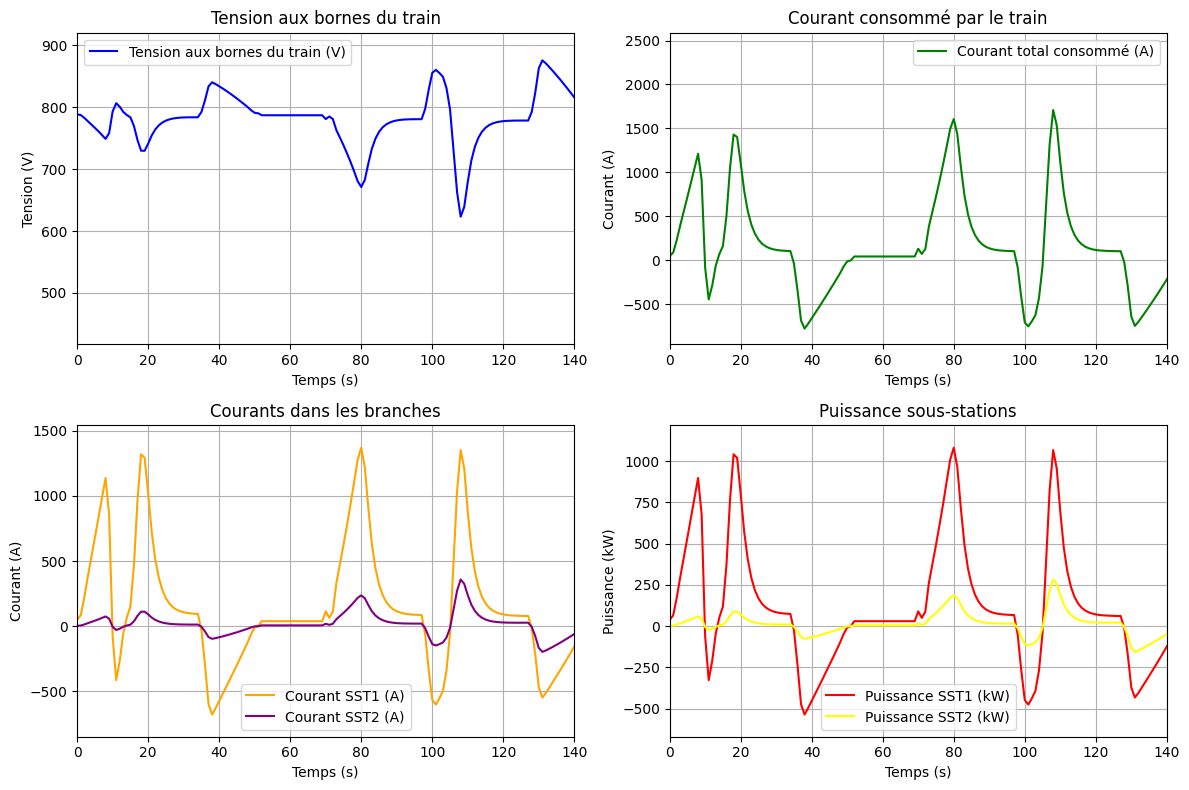

In [204]:


# Calcul des résistances 
R_LAC1 = rho_LAC * x
R_rail1 = rho_rail * x
R_LAC2 = rho_LAC * (L_total - x)
R_rail2 = rho_rail * (L_total - x)

# Résistance équivalente totale
R_eq = (R_LAC1 + R_rail1 + R_ss1) * (R_LAC2 + R_rail2 + R_ss1) / (
    R_LAC1 + R_rail1 + R_ss1 + R_LAC2 + R_rail2 + R_ss1
)

# Initialisation des variables 
V_train = np.zeros_like(t)
I_train = np.zeros_like(t)
I1 = np.zeros_like(t)
I2 = np.zeros_like(t)

# Contraintes
V_min=500

for i in range(len(t)):
    # Limiter la puissance demandé  # Puissance plafonnée

    # Calcul du discriminant
    discriminant = V_ss1**2 - 4 * R_eq[i]* P_train[i]

    # Calcul de la tension aux bornes du train
    if discriminant >= 0:
        V_train[i] = (V_ss1 + np.sqrt(discriminant)) / 2  # Solution réelle
    else:
        V_train[i] = V_min # Fixer à la valeur minimale admissible

    # Calcul des courants
    I1[i] = (V_ss1 - V_train[i]) / (R_LAC1[i] + R_rail1[i] + R_ss1)
    I2[i] = (V_ss1 - V_train[i]) / (R_LAC2[i] + R_rail2[i] + R_ss1)
    I_train[i] = I1[i] + I2[i]  # Somme des courants des deux sous-stations

# Calcul des puissances fournies 
P_ss1 = V_ss1 * I1
P_ss2 = V_ss1 * I2
delta_V_max = V_ss1 - np.min(V_train)  # Chute de tension maximale
print(f"Chute de tension maximale : {delta_V_max:.2f} V")

# Visualisation des résultats 
plt.figure(figsize=(12, 8))

# 1. Tension aux bornes du train
plt.subplot(2, 2, 1)
plt.plot(t, V_train, label="Tension aux bornes du train (V)", color="blue")
plt.xlabel("Temps (s)")
plt.ylabel("Tension (V)")
plt.title("Tension aux bornes du train")
plt.legend()
plt.grid()
# Limiter les bornes de l'axe x
plt.xlim(0, 140)  # Par exemple, entre 0 et 10 secondes

# 2. Courant total consommé
plt.subplot(2, 2, 2)
plt.plot(t, I_train, label="Courant total consommé (A)", color="green")
plt.xlabel("Temps (s)")
plt.ylabel("Courant (A)")
plt.title("Courant consommé par le train")
plt.legend()
plt.grid()
#Limiter les bornes de l'axe x
plt.xlim(0, 140)  # Par exemple, entre 0 et 10 secondes 

# 3. Courants dans les branches
plt.subplot(2, 2, 3)
plt.plot(t, I1, label="Courant SST1 (A)", color="orange")
plt.plot(t, I2, label="Courant SST2 (A)", color="purple")
plt.xlabel("Temps (s)")
plt.ylabel("Courant (A)")
plt.title("Courants dans les branches")
plt.legend()
plt.grid()
#Limiter les bornes de l'axe x
plt.xlim(0, 140)  # Par exemple, entre 0 et 10 secondes

# 4. Puissance fournie par les sous-stations
plt.subplot(2, 2, 4)
plt.plot(t, P_ss1 / 1e3, label="Puissance SST1 (kW)", color="red")
plt.plot(t, P_ss2 / 1e3, label="Puissance SST2 (kW)", color="yellow")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (kW)")
plt.title("Puissance sous-stations")
plt.legend()
plt.grid()
#Limiter les bornes de l'axe x
plt.xlim(0, 140)  # Par exemple, entre 0 et 10 secondes

plt.tight_layout()
plt.show()


## Résultats obtenus sans batterie  :

Graphique 1 : Tension aux bornes du train
    On observe des oscillations autour de 800–900 V, avec des légères baisses sous 550 V, (proches de la limite) lors des phases d’accélération. Ces chutes de tension sont cohérentes avec la modélisation sans batterie car :
    En accélération, la demande de puissance est élevée, provoquant une chute de tension. En effet, l’absence de stockage (=batterie) entraîne une  dépendance à la LAC,  qui est insuffisante pour compenser les besoins transitifs du système​. 

Graphique 2 : Courant total consommé par le train
    On observe des pics atteignant environ 1500 A en accélération et valeurs légèrement négatives lors du freinage ( qui témoigne de l'éxcès d'énergie et donc d'une perte par le rhéostat).Ces variations sont conformes au comportement attendu sans batterie.

Graphique 3 : Courants dans les SST1 et SST2
    On observe dans la globalité des variations semblables dans les deux SST, avec des pics atteignant environ 1250 A. Toutefois,la position du tram sur la ligne influence la charge fournie par chaque SST.Cela entraîne des courants asymétriques et une surcharge potentielle des SST proches.

Graphique 4 : Puissance fournie par les sous-stations
    On observe des pics atteignant environ 800-1000 kW. On peut aussi voir des valeurs négatives qui reflètent la dissipation d’énergie pendant le freinage. Ces résultats sont cohérents avec un système sans batterie (=impossibilité de récupérer l'énergie disspiée).

## Conclusion et limites du sytème sans batterie :

-Chutes de tension > 250 V : instabilité du système qui peut etre rectifié par un système de stockage. On espère etre < à 100 V avec la batterie. 

-Pics de courant et puissance élevés : dépendance excessive à la LAC.La batterie permettrait de limiter ces tranistions et d’améliorer l’efficacité énergétique en instroduisant une source d'énergie locale.

-Absence de récupération d’énergie : l’énergie au freinage est dissipée dans un rhéostat au lieu d’être réutilisée. Une batterie pourrait réduire les pertes et réutiliser cette énergie efficacement.

## 2-Dimensionnement du système de stockage avec batterie


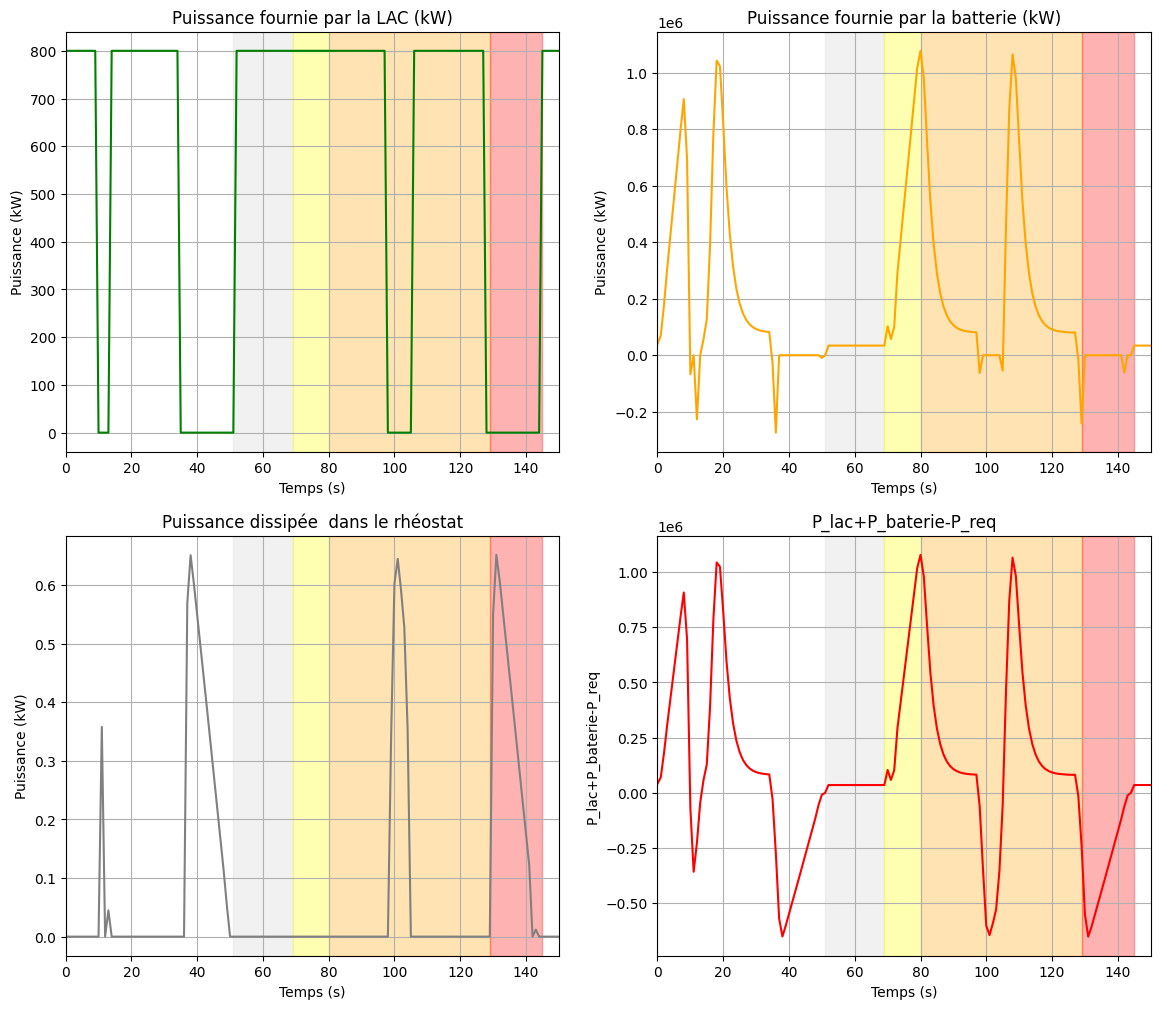

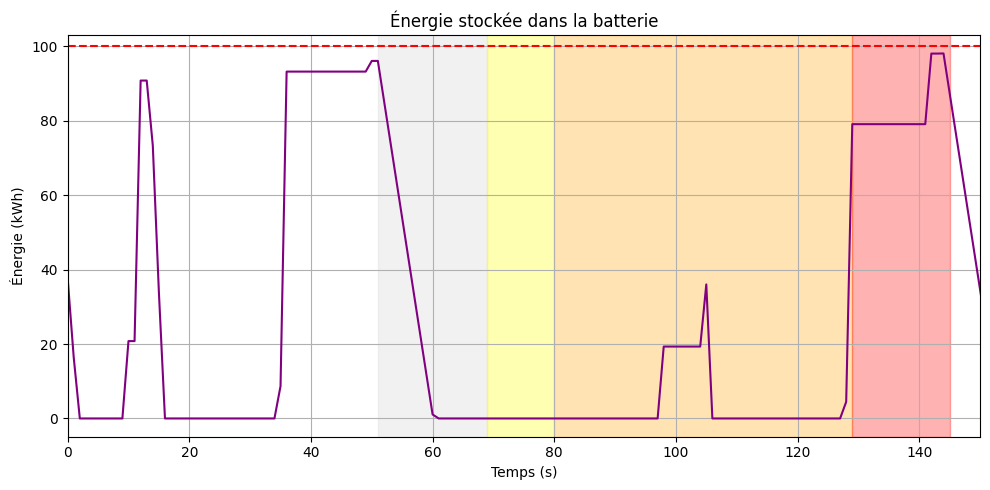

In [ ]:
# Paramètres du système
Energie_batterie_max = 100  # Capacité max de la batterie en kWh
Energie_batterie = 50       # État initial de la batterie en kWh
P_seuil = 800             # Puissance maximale  en kW
V_min = 500                 # Tension minimale admissible en V
eta_batterie = 0.9          # Rendement global de la batterie

# Initialisation
P_lac = np.zeros_like(t)                   # Puissance fournie par la Lac
P_batterie = np.zeros_like(t)              # Puissance fournie par la batterie
P_reho = np.zeros_like(t)                  # Puissance dissipée dans le rhéostat
Energie_batterie_temps = np.zeros_like(t)  # Évolution de l’énergie de la batterie
V_train = np.zeros_like(t)                 # Tension aux bornes du train


for i in range(len(t)):
    # Phase de traction
    if P_train[i] > 0:  # Si le train consomme de la puissance
        if P_train[i] <= P_seuil:
            # La LAC fournit toute la puissance demandée
            P_lac[i] = P_train[i]
            P_batterie[i] = 0
        else:
            # La LAC est saturée, la batterie complète l’excédent
            P_lac[i] = P_seuil
            P_batterie[i] = P_train[i] - P_lac[i]

    # Phase de freinage
    else:  # Si le train est en freinage (P_train <= 0)
        P_batterie_fictif = P_train[i]  # Puissance récupérable
        P_lac[i] = 0

        # Gestion de la batterie et du rhéostat
        if Energie_batterie + (-P_batterie_fictif * (dt / 3600)) >= Energie_batterie_max:
            # Batterie pleine, dissipation dans le rhéostat
            P_reho[i] = -P_batterie_fictif
            P_batterie[i] = 0
        else:
            # Stockage dans la batterie
            P_batterie[i] = P_batterie_fictif
            P_reho[i] = 0

    # Mise à jour de l'énergie de la batterie avec rendement
    Energie_batterie += -P_batterie[i] * (dt / 3600) / eta_batterie

    # Contraintes sur l'énergie de la batterie
    Energie_batterie = max(0,Energie_batterie)
    Energie_batterie_temps[i] = Energie_batterie

    # Calcul de la tension aux bornes du train
    R_eq = (R_LAC1[i] + R_rail1[i] + R_ss1) * (R_LAC2[i] + R_rail2[i] + R_ss1) / (
        R_LAC1[i] + R_rail1[i] + R_ss1 + R_LAC2[i] + R_rail2[i] + R_ss1)
    I_train = (P_lac[i] + P_batterie[i]) / V_ss1  # Inclure la batterie dans le courant total
    Preq= P_lac+P_batterie - P_reho


# Graphiques des résultats
# Graphique des puissances fournie et dissipé
plt.figure(figsize=(14, 12))

# 1. Puissance fournie par la LAC
plt.subplot(2, 2, 1)
plt.plot(t, P_lac, color="green")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (kW)")
plt.title("Puissance fournie par la LAC (kW)")
plt.xlim(0, 150)  #Limiter les bornes de l'axe x
plt.grid()
plt.axvspan(phases['arret'][0], phases['arret'][1], color='lightgrey', alpha=0.3)  # Arret
plt.axvspan(phases['demarrage'][0], phases['demarrage'][1], color='yellow', alpha=0.3)  # Demarrage
plt.axvspan(phases['vitesse_constante'][0], phases['vitesse_constante'][1], color='orange', alpha=0.3)  # Vitesse constante
plt.axvspan(phases['freinage'][0], phases['freinage'][1], color='red', alpha=0.3)  # Freinage


# 2. Puissance fournie par la batterie 
plt.subplot(2, 2, 2)
plt.plot(t, P_batterie, color="orange")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (kW)")
plt.title("Puissance fournie par la batterie (kW)")
plt.xlim(0, 150)  #Limiter les bornes de l'axe x
plt.grid()
plt.axvspan(phases['arret'][0], phases['arret'][1], color='lightgrey', alpha=0.3)  # Arret
plt.axvspan(phases['demarrage'][0], phases['demarrage'][1], color='yellow', alpha=0.3)  # Demarrage
plt.axvspan(phases['vitesse_constante'][0], phases['vitesse_constante'][1], color='orange', alpha=0.3)  # Vitesse constante
plt.axvspan(phases['freinage'][0], phases['freinage'][1], color='red', alpha=0.3)  # Freinage


# 3. Puissance dissipation
plt.subplot(2, 2, 3)
plt.plot(t, P_reho / 1e6, color="grey")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (kW)")
plt.title("Puissance dissipée  dans le rhéostat")
plt.xlim(0, 150)  #Limiter les bornes de l'axe x
plt.grid()
plt.axvspan(phases['arret'][0], phases['arret'][1], color='lightgrey', alpha=0.3)  # Arret
plt.axvspan(phases['demarrage'][0], phases['demarrage'][1], color='yellow', alpha=0.3)  # Demarrage
plt.axvspan(phases['vitesse_constante'][0], phases['vitesse_constante'][1], color='orange', alpha=0.3)  # Vitesse constante
plt.axvspan(phases['freinage'][0], phases['freinage'][1], color='red', alpha=0.3)  # Freinage


# 4. Somme des puissance P_train =P_lac+P_baterie-P_req
plt.subplot(2, 2, 4)
plt.plot(t, Preq, color="red")
plt.xlabel("Temps (s)")
plt.ylabel("P_lac+P_baterie-P_req")
plt.title("P_lac+P_baterie-P_req")
plt.xlim(0, 150)  #Limiter les bornes de l'axe x
plt.grid()
plt.axvspan(phases['arret'][0], phases['arret'][1], color='lightgrey', alpha=0.3)  # Arret
plt.axvspan(phases['demarrage'][0], phases['demarrage'][1], color='yellow', alpha=0.3)  # Demarrage
plt.axvspan(phases['vitesse_constante'][0], phases['vitesse_constante'][1], color='orange', alpha=0.3)  # Vitesse constante
plt.axvspan(phases['freinage'][0], phases['freinage'][1], color='red', alpha=0.3)  # Freinage

# Énergie stockée dans la batterie
plt.figure(figsize=(10, 5))
plt.plot(t, Energie_batterie_temps, color="purple")
plt.axhline(y=Energie_batterie_max, color="red", linestyle="--", label="Capacité max")
plt.xlabel("Temps (s)")
plt.ylabel("Énergie (kWh)")
plt.title("Énergie stockée dans la batterie")
plt.xlim(0, 150)  #Limiter les bornes de l'axe x
plt.grid()

# Ajout des fonds colorés pour les phases
plt.axvspan(phases['arret'][0], phases['arret'][1], color='lightgrey', alpha=0.3)  # Arret
plt.axvspan(phases['demarrage'][0], phases['demarrage'][1], color='yellow', alpha=0.3)  # Demarrage
plt.axvspan(phases['vitesse_constante'][0], phases['vitesse_constante'][1], color='orange', alpha=0.3)  # Vitesse constante
plt.axvspan(phases['freinage'][0], phases['freinage'][1], color='red', alpha=0.3)  # Freinage

plt.tight_layout()
plt.show()


# Résultats obtenus avec batterie 

**Phase de traction :**

- La batterie contribue positivement à la puissance lorsque $P_{train}>P_{LAC_max}$
​- Une diminution progressive de l'énergie stockée est visible.

**Phase de freinage :**

- Lors du freinage, une partie de l'énergie récupérée est stockée dans la batterie, entraînant une augmentation de son énergie.
- Si la batterie atteint sa capacité maximale, l'excédent est dissipé dans le rhéostat, ce qui est clairement visible sur le graphique de 
$ 𝑃_{rhéostat}$

**Tension aux bornes du train :**

- Le comportement de la tension $V_{train}$ ​pourrait également être vérifié pour garantir qu'elle reste au-dessus de la tension minimale admissible $V_{min}$
​
- Cela permettrait de confirmer le bon dimensionnement des résistances et des puissances fournies.

Pour vérifier la cohérence des résultats obtenus, nous utilisons la relation suivante :

$$ 𝑃_{train} = 𝑃_{LAC} +𝑃_{batterie}−𝑃_{rhéostat}$$

 
Les graphiques générés à partir de cette formule sont conformes à ceux représentant la puissance demandée par le train, ce qui confirme la validité des calculs.


Chute de tension maximale : 45.09 V


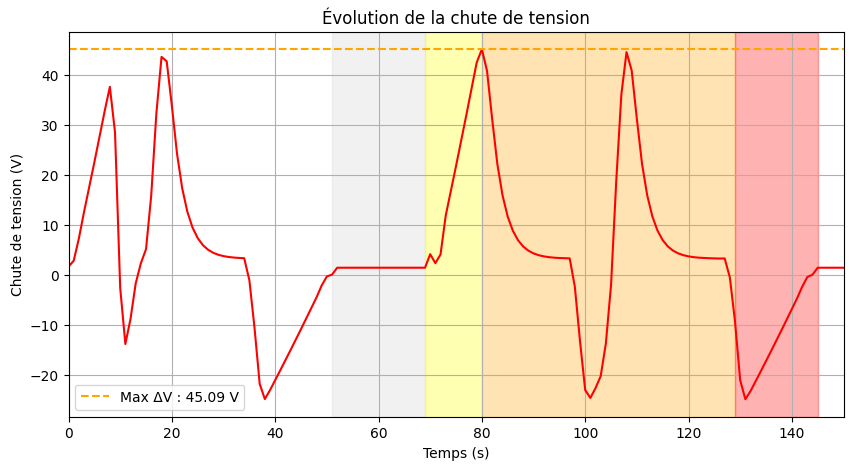

In [177]:
# Calcul de la chute de tension maximale
discriminant = V_ss1 ** 2 - 4 * R_eq * P_train
V_train = np.where(discriminant >= 0, (V_ss1 + np.sqrt(discriminant)) / 2, V_min)
delta_V= V_ss1 - V_train
delta_V_max = V_ss1 - np.min(V_train)
print(f"Chute de tension maximale : {delta_V_max:.2f} V")

# Évolution de la chute de tension
plt.figure(figsize=(10, 5))
plt.plot(t, delta_V, color="red")
plt.axhline(y=delta_V_max, color='orange', linestyle='--', label=f"Max ΔV : {delta_V_max:.2f} V")
plt.xlabel("Temps (s)")
plt.ylabel("Chute de tension (V)")
plt.title("Évolution de la chute de tension")
plt.xlim(0, 150)  #Limiter les bornes de l'axe x
plt.legend()
plt.grid()

# Ajout des fonds colorés pour les phases
plt.axvspan(phases['arret'][0], phases['arret'][1], color='lightgrey', alpha=0.3)  # Arret
plt.axvspan(phases['demarrage'][0], phases['demarrage'][1], color='yellow', alpha=0.3)  # Demarrage
plt.axvspan(phases['vitesse_constante'][0], phases['vitesse_constante'][1], color='orange', alpha=0.3)  # Vitesse constante
plt.axvspan(phases['freinage'][0], phases['freinage'][1], color='red', alpha=0.3)  # Freinage


## **Conclusion :** 

La comparaison entre les deux scénarios met en évidence les avantages de l’intégration d’une batterie. Tandis que la chute de tension sans batterie atteint un niveau potentiellement problématique (350,24 V), l’ajout de la batterie permet de la réduire considérablement (45,09 V). Cette amélioration démontre l’importance du stockage d’énergie pour garantir une gestion stable et fiable de l’alimentation, et souligne l’efficacité de la solution de stockage dans le tramway pour maintenir la tension dans des limites acceptables.

## 3-Methode de Monte Carlo


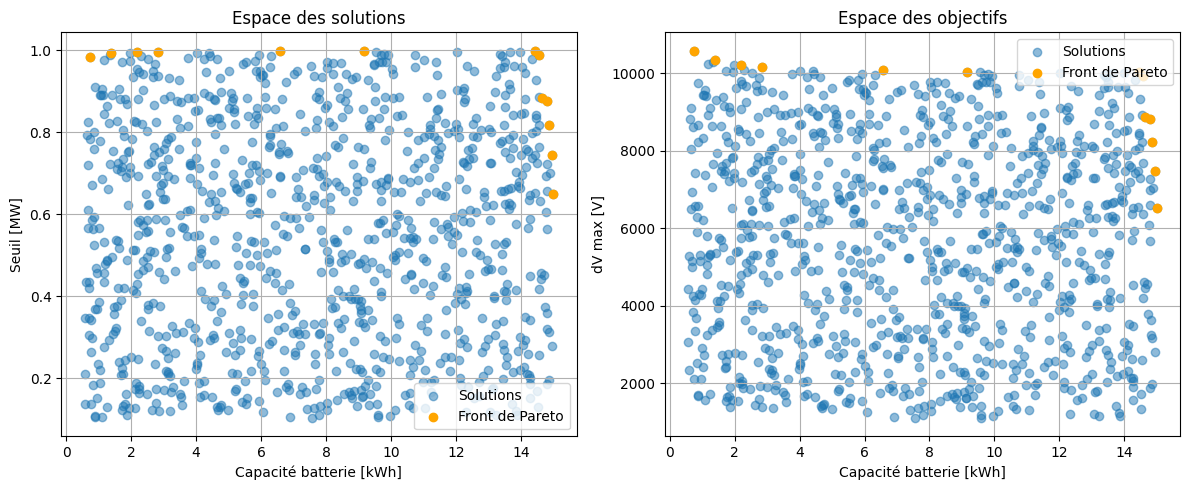

In [34]:
#Paramètres du système
eta_batterie = 0.9  # Rendement batterie
eta_conversion = 0.8  # Rendement de conversion (moteur + convertisseurs)

# Simulation des performances
np.random.seed(42)

# Générer des échantillons
n_samples = 1000
capacities = np.random.uniform(0.5, 15, n_samples)  # Capacité en kWh
seuils = np.random.uniform(0.1, 1.0, n_samples)  # Seuil en MW (converti en kW dans les calculs)

# Fonctions pour calculer les objectifs (modifiées pour intégrer les rendements)
def simulate_performance(capacity, seuil):
    # Simulation de la chute de tension avec rendements
    if capacity > 0 and seuil > 0:  # Ajout d'un contrôle pour éviter les divisions par zéro
        power_available = capacity * eta_batterie * eta_conversion  # Puissance utile après pertes
        delta_V_max = 400 / power_available + seuil * 10  # seuil en kW
    else:
        delta_V_max = np.inf  # Pénalité pour valeurs non valides
    cost = capacity
    return delta_V_max, cost

# Calcul des performances
performances = np.array([simulate_performance(cap, seuil * 1000) for cap, seuil in zip(capacities, seuils)])
delta_V_max = performances[:, 0]
cost = performances[:, 1]

# Identification des solutions non dominées (front de Pareto)
def pareto_front(cost, delta_V_max):
    is_efficient = np.ones(cost.shape, dtype=bool)
    for i in range(len(cost)):
        if is_efficient[i]:
            is_efficient[is_efficient] = ~((cost[is_efficient] < cost[i]) & (delta_V_max[is_efficient] <= delta_V_max[i]))
            is_efficient[i] = True  # Toujours conserver soi-même
    return is_efficient

pareto = pareto_front(cost, delta_V_max)

# Tracé des résultats
plt.figure(figsize=(12, 5))

# Graphique 1 : Espace des solutions
plt.subplot(1, 2, 1)
plt.scatter(capacities, seuils, label='Solutions', alpha=0.5)
plt.scatter(capacities[pareto], seuils[pareto], color='orange', label='Front de Pareto')
plt.xlabel('Capacité batterie [kWh]')
plt.ylabel('Seuil [MW]')
plt.title('Espace des solutions')
plt.legend()
plt.grid(True)

# Graphique 2 : Espace des objectifs
plt.subplot(1, 2, 2)
plt.scatter(cost, delta_V_max, label='Solutions', alpha=0.5)
plt.scatter(cost[pareto], delta_V_max[pareto], color='orange', label='Front de Pareto')
plt.xlabel('Capacité batterie [kWh]')
plt.ylabel('dV max [V]')
plt.title('Espace des objectifs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


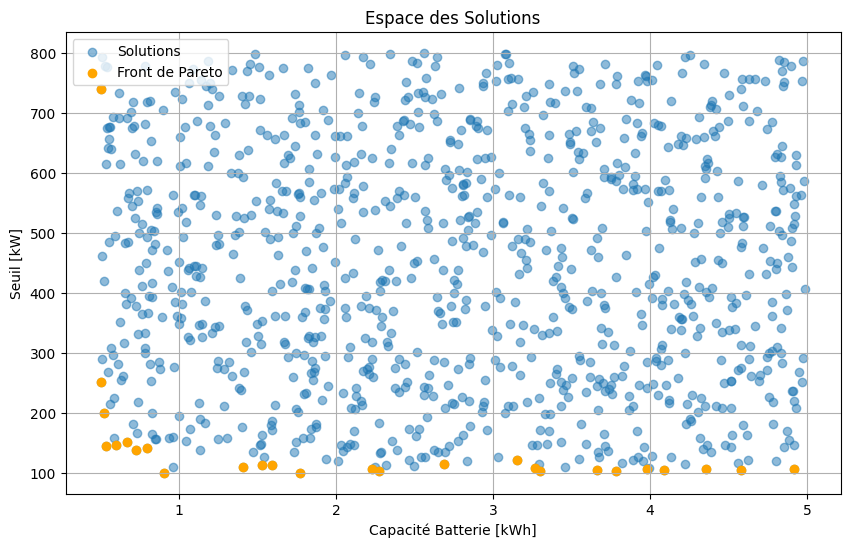

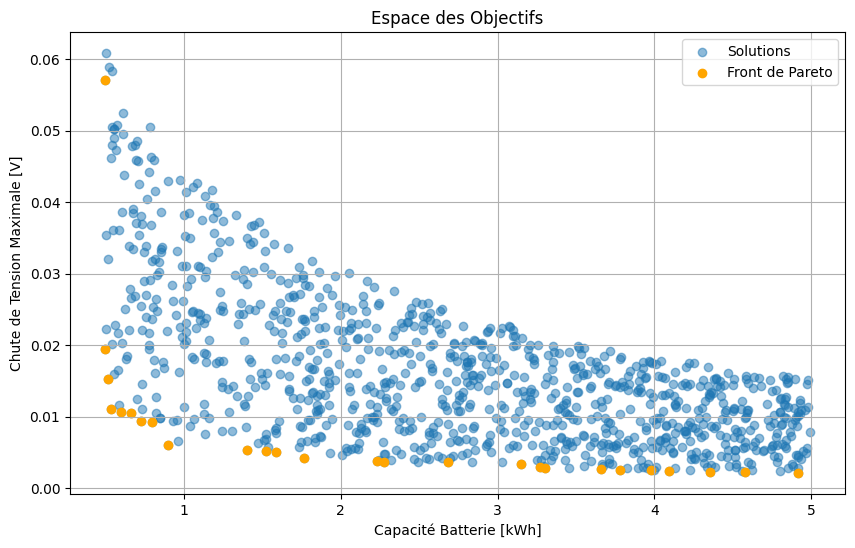

In [35]:

# Paramètres du système
rho_LAC = 95e-6  # Ohm/m
rho_rail = 10e-6  # Ohm/m
eta_batterie = 0.9

# Contraintes physiques et plage d'exploration
capacite_min = 0.5  # kWh
capacite_max = 5.0  # kWh
seuil_min = 100  # kW
seuil_max = 800  # kW

# Nombre d'échantillons Monte Carlo
n_points = 1000

# Génération aléatoire des paramètres
capacites = np.random.uniform(capacite_min, capacite_max, n_points)
seuils = np.random.uniform(seuil_min, seuil_max, n_points)

# Fonction de calcul de la chute de tension (simplifiée)
def calcul_chute_tension(capacite, seuil):
    # Facteurs liés à la résistance et au rendement
    resistance = rho_LAC + rho_rail
    perte = (1 - eta_batterie)

    # Modèle simplifié pour Delta V
    delta_V = (resistance * seuil / (capacite + 1)) * (1 + perte)
    return delta_V

# Calcul des performances
chutes_tension = np.array([calcul_chute_tension(c, s) for c, s in zip(capacites, seuils)])

# Déterminer les solutions non dominées (Front de Pareto)
def pareto_front(capacites, chutes):
    is_pareto = np.ones(len(capacites), dtype=bool)
    for i in range(len(capacites)):
        for j in range(len(capacites)):
            if (capacites[j] <= capacites[i] and chutes[j] < chutes[i]) or \
               (capacites[j] < capacites[i] and chutes[j] <= chutes[i]):
                is_pareto[i] = False
                break
    return is_pareto

pareto = pareto_front(capacites, chutes_tension)

# Tracé des espaces de solutions
plt.figure(figsize=(10, 6))
plt.scatter(capacites, seuils, label='Solutions', alpha=0.5)
plt.scatter(capacites[pareto], seuils[pareto], color='orange', label='Front de Pareto')
plt.xlabel('Capacité Batterie [kWh]')
plt.ylabel('Seuil [kW]')
plt.title('Espace des Solutions')
plt.legend()
plt.grid(True)
plt.show()

# Tracé des objectifs
plt.figure(figsize=(10, 6))
plt.scatter(capacites, chutes_tension, label='Solutions', alpha=0.5)
plt.scatter(capacites[pareto], chutes_tension[pareto], color='orange', label='Front de Pareto')
plt.xlabel('Capacité Batterie [kWh]')
plt.ylabel('Chute de Tension Maximale [V]')
plt.title('Espace des Objectifs')
plt.legend()
plt.grid(True)
plt.show()



## 4-Résolution par algorithme génétique		

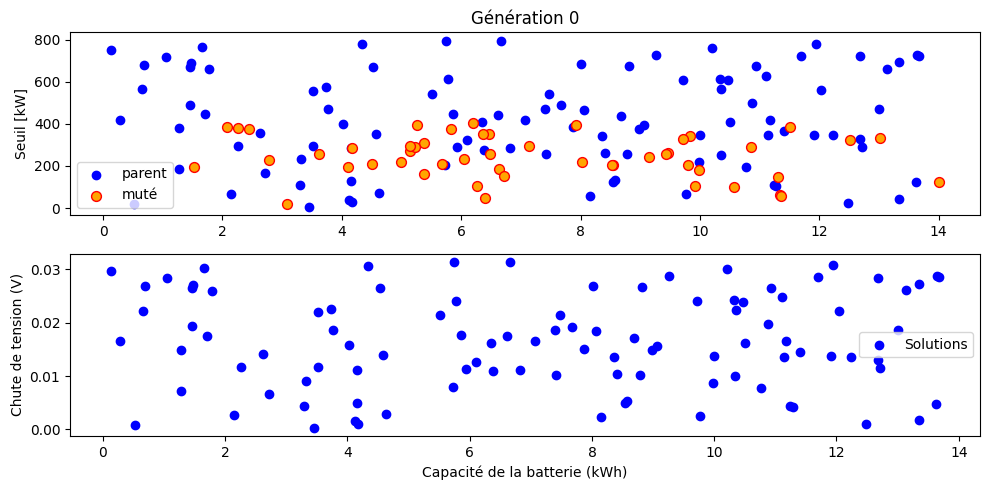

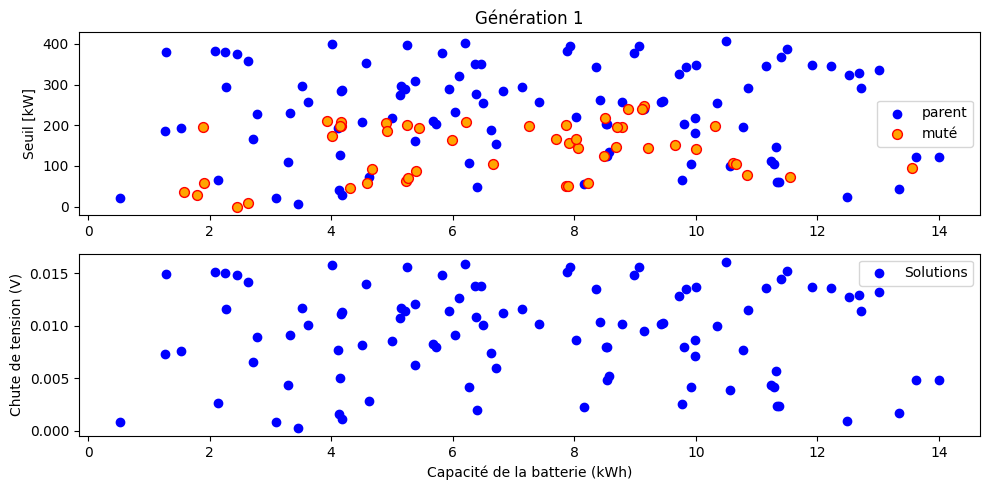

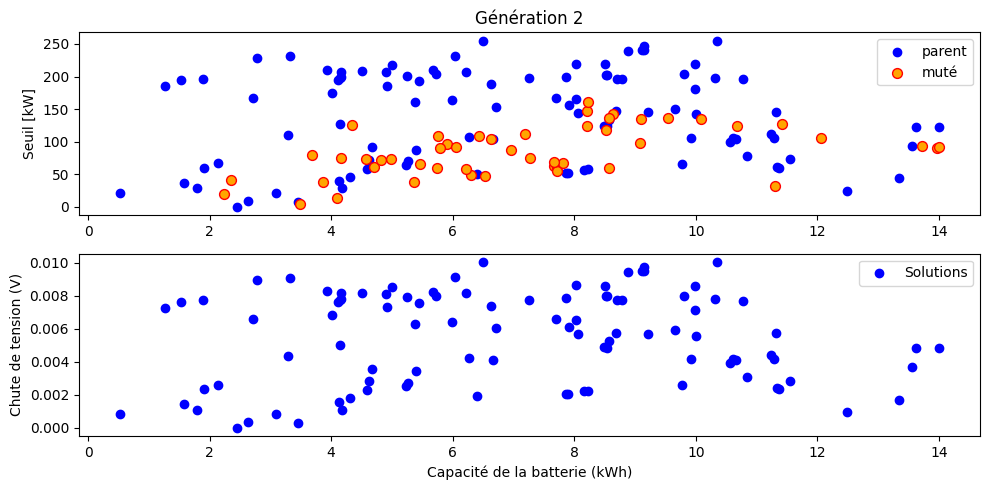

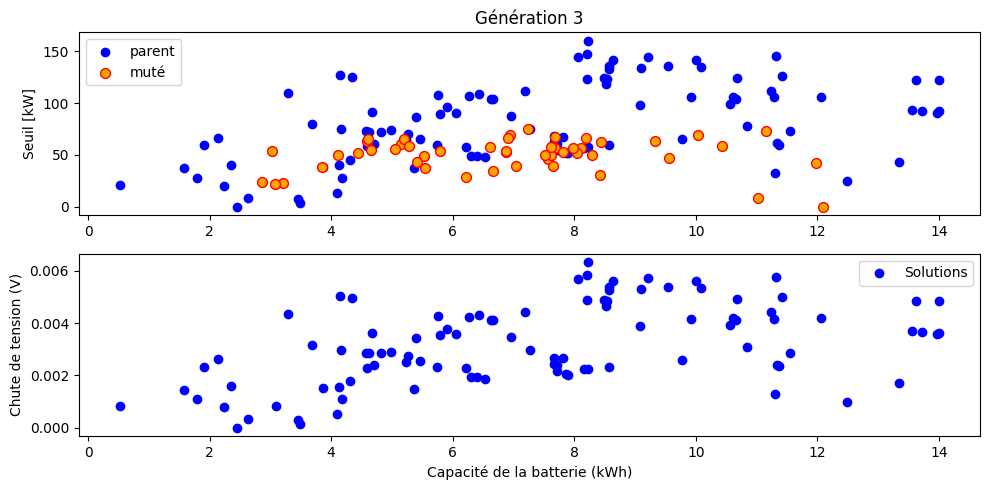

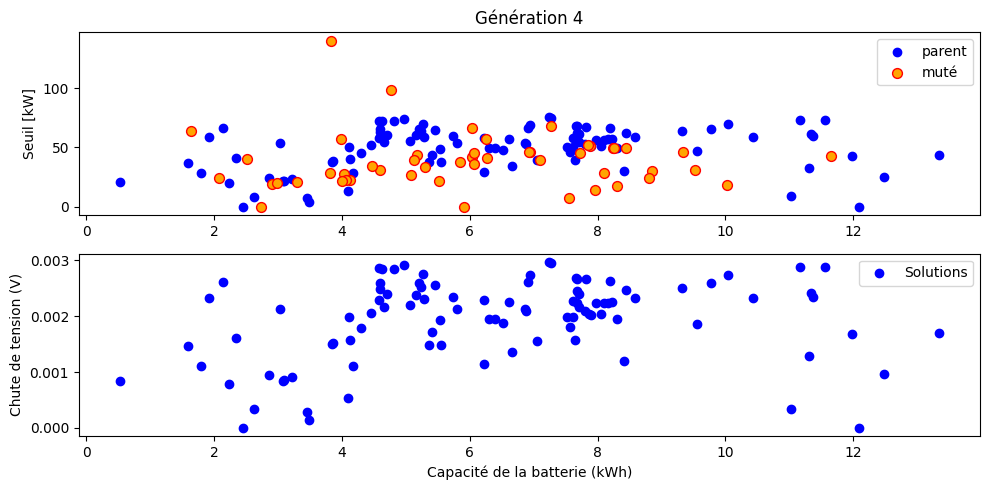

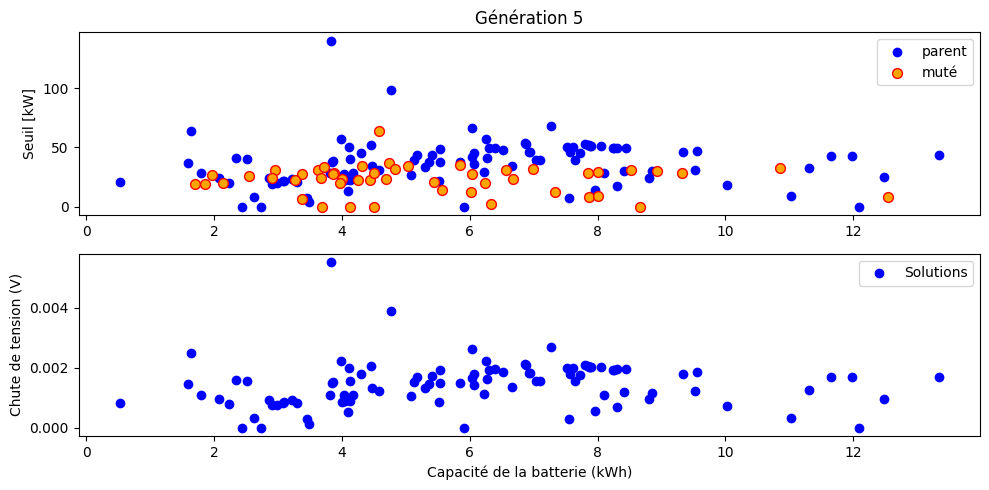

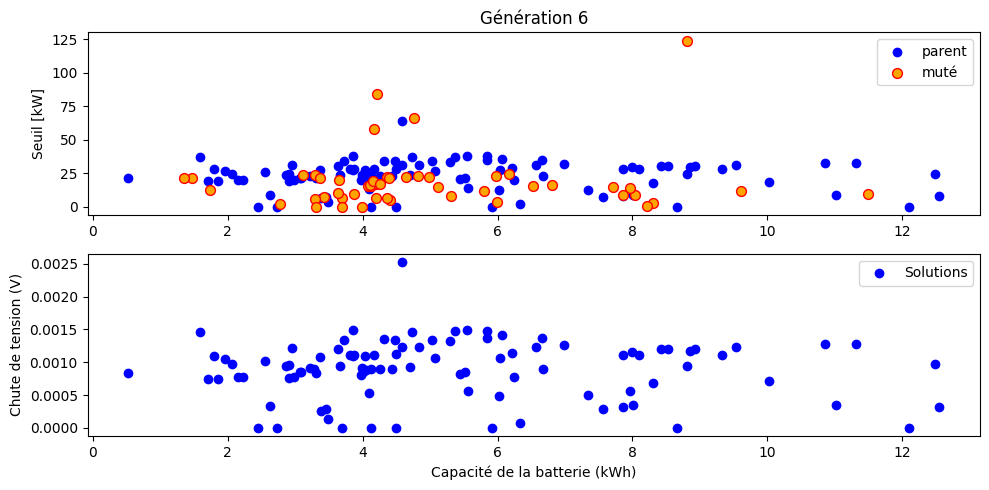

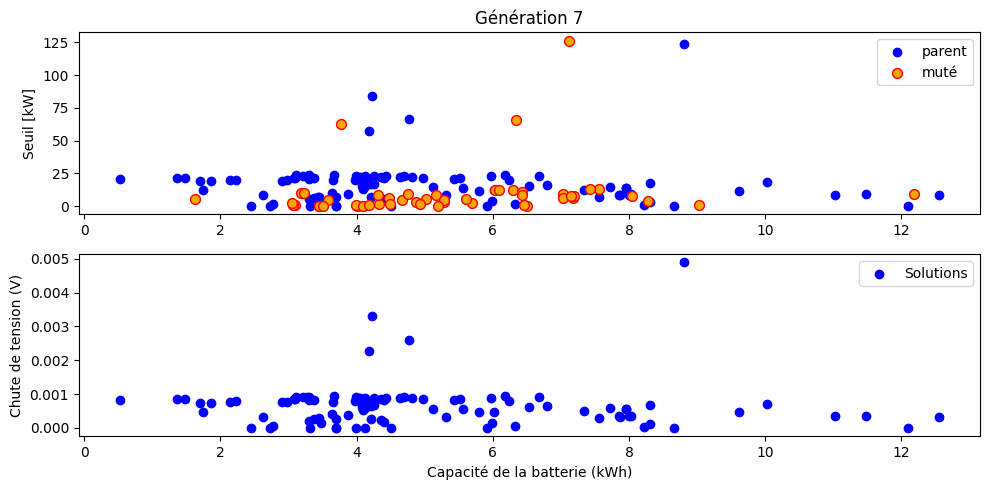

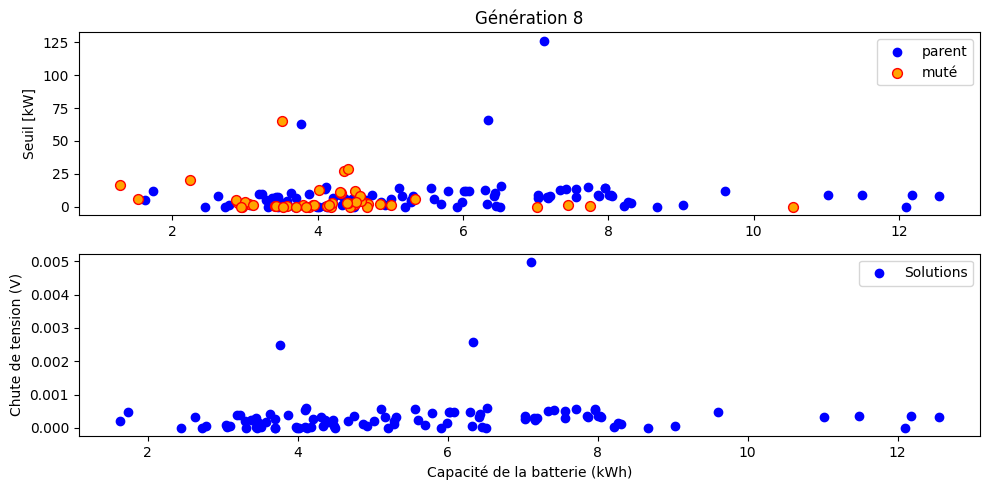

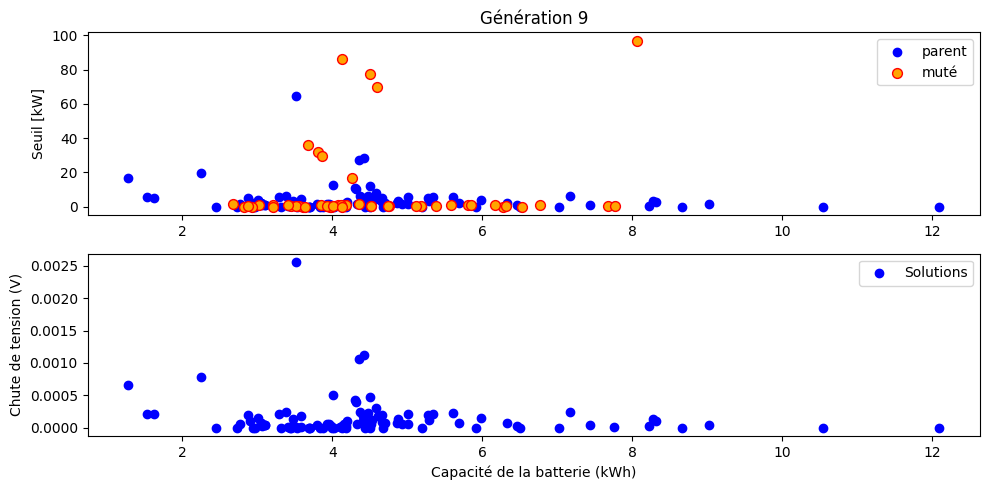

In [202]:
# Paramètres
taille_population = 100
nombre_generations = 10
nombre_genes = 2  # Capacité de la batterie et seuil de puissance
capacite = 14
P_seuil = 800

# Initialisation de la population
population = np.random.rand(taille_population, nombre_genes) * [capacite, P_seuil]

# Stockage des résultats
toutes_les_generations = []
mutations = []

# Calcul des performances
def evaluer(individu):
    capacite, seuil = individu
    P_train = seuil
    discriminant = V_ss1 ** 2 - 4 * R_eq * P_train
    V_train = np.where(discriminant >= 0, (V_ss1 + np.sqrt(discriminant)) / 2, V_min)
    delta_V_max = V_ss1 - np.min(V_train)
    return seuil, delta_V_max

# Calcul du rang des individus
def domine(ind1, ind2):
    return all(x <= y for x, y in zip(ind1, ind2)) and any(x < y for x, y in zip(ind1, ind2))

# Classement non dominé
def tri_non_domine_rapide(population):
    fronts = [[]]
    comptage_domination = [0] * len(population)
    ensembles_domines = [[] for _ in range(len(population))]
    
    for p in range(len(population)):
        for q in range(len(population)):
            if domine(population[p], population[q]):
                ensembles_domines[p].append(q)
            elif domine(population[q], population[p]):
                comptage_domination[p] += 1
        if comptage_domination[p] == 0:
            fronts[0].append(p)

    i = 0
    while len(fronts[i]) > 0:
        prochain_front = []
        for p in fronts[i]:
            for q in ensembles_domines[p]:
                comptage_domination[q] -= 1
                if comptage_domination[q] == 0:
                    prochain_front.append(q)
        i += 1
        fronts.append(prochain_front)
    return fronts[:-1]

# Croisement
def croisement(parent1, parent2):
    alpha = random.uniform(-0.1, 1.1)
    enfant = alpha * parent1 + (1 - alpha) * parent2
    enfant = np.clip(enfant, [0, 0], [capacite, P_seuil])
    return enfant

# Mutation
def mutation(individu, taux_mutation=0.2):
    if random.random() < taux_mutation:
        individu[0] += np.random.normal(0, 1)  # Mutation sur la capacité
        individu[0] = np.clip(individu[0], 0, capacite)  # Limiter à [0, 14]
    if random.random() < taux_mutation:
        individu[1] += np.random.normal(0, 50)  # Mutation sur le seuil de puissance
        individu[1] = np.clip(individu[1], 0, P_seuil)  # Limiter à [0, 800]
    return individu

# Algorithme génétique
for generation in range(nombre_generations):
    performance = [evaluer(ind) for ind in population]
    toutes_les_generations.append((population.copy(), performance))

    # Classement des fronts
    fronts = tri_non_domine_rapide(performance)

    # Sélection des meilleurs
    nouvelle_population = []
    for front in fronts:
        if len(nouvelle_population) + len(front) > taille_population:
            break
        nouvelle_population.extend([population[i] for i in front])
    population = np.array(sorted(nouvelle_population, key=lambda x: evaluer(x)[1])[:taille_population // 2])

    # Croisement et mutation
    nouvelles_mutations = []
    while len(population) < taille_population:
        p1, p2 = random.sample(list(population), 2)
        enfant = croisement(p1, p2)
        enfant = mutation(enfant)  # Appliquer la mutation
        nouvelles_mutations.append(enfant)
        population = np.vstack([population, enfant])
    mutations.append(nouvelles_mutations)

# Affichage des résultats
for gen_idx, (pop, perf) in enumerate(toutes_les_generations):
    couts, chutes = zip(*perf)
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.scatter(pop[:, 0], pop[:, 1], label='parent', color='blue')
    if gen_idx < len(mutations):
        mut_pop = np.array(mutations[gen_idx])
        if len(mut_pop) > 0:
            plt.scatter(mut_pop[:, 0], mut_pop[:, 1], label='muté', color='orange', s=50, edgecolors='red')
    plt.ylabel("Seuil [kW]")
    plt.title(f"Génération {gen_idx}")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.scatter(couts, chutes, label="Solutions", color='blue')
    plt.xlabel("Capacité de la batterie (kWh)")
    plt.ylabel("Chute de tension (V)")
    plt.legend()

    plt.tight_layout()